In [1]:
import numpy as np
import pickle
import pandas as pd

import torch
import swyft.lightning as sl

import seaborn as sns
sns.set_theme(style="whitegrid", font="STIXgeneral")

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [2]:
# Redshifts
reds = [10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15])

# Priors
vmin = np.array([10, 4.2, 8])
vmax = np.array([100, 5.4, 25])

# Path for mock observation and noise
noisePath = "./ska_low_noise.npy"
obsPath = "./mockObs.pkl"

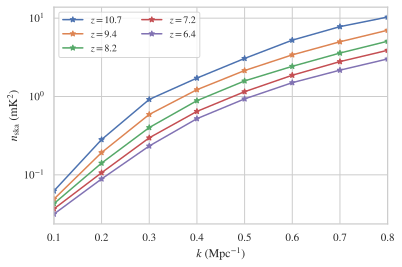

In [3]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)[5:]
instNoiseT = torch.tensor(instNoise, dtype=torch.float32).to('cuda')

fig, ax = plt.subplots()
k_vals = np.linspace(0.1, 0.8, 8)
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=10)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

In [5]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro-3.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=128, idx_range=[0, 18_500])
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=128, idx_range=[18_500, 23_000])

In [6]:
zarrSamples = zs.get_sample_store()

In [7]:
trainer_1D = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100,
                             **sl.tensorboard_config(name = 'exptOptm', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
import torch.nn as nn

class TimeSharing(nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.softMax = torch.nn.Softmax(dim=0)
        self.size = size_in
        self.register_buffer("bin_nums",
                             torch.nn.Parameter(torch.tensor(1.e-1*np.arange(5),
                                                             dtype = torch.float32,
                                                             device="cuda")))
        self.bin_to_time = torch.nn.Sequential(
            torch.nn.LazyLinear(256, device='cuda'),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(256, device='cuda'),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(256, device='cuda'),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(5, device='cuda'),
            torch.nn.Dropout(0.05)
        )
        
    def get_times(self):
        self.t_unnormalized = self.bin_to_time(self.bin_nums)
        return 5000.*self.softMax(self.t_unnormalized)

    def forward(self, x):
        return x*1000./self.get_times()
    

class Network_1D(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-4)
        self.n_features = 16
        self.l = torch.nn.Linear(40, 16, device='cuda')
        self.timeShare = TimeSharing(5)
        
        self.classifier = sl.RatioEstimatorMLP1d(self.n_features, len(vtrue), hidden_features=256,
                                                 num_blocks=2, dropout=0.1)
        
    def forward(self, A, B):
        instNoiseT_new = self.timeShare(instNoiseT.T)
        instNoiseT_new = instNoiseT_new.T
        
        for i in range(len(reds)):
            mu = A['pk_mu_z%.1f'%reds[i]]
            sv = A['pk_sv_z%.1f'%reds[i]]
            
            # Total noise including the intrumental noise and sample variance
            total_noise_val = torch.sqrt(instNoiseT_new[i]**2. + sv**2.)
            n = torch.randn(*total_noise_val.shape, device='cuda')*total_noise_val
        
            A['pk_z%.1f'%reds[i]] = mu + n

        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [9]:
network_1D = Network_1D()

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
times0 = network_1D.timeShare.get_times()
print("Initial time distribution:\n", times0)

Initial time distribution:
 tensor([ 946.1289,  945.7433, 1064.1945, 1012.3047, 1031.6284],
       device='cuda:0', grad_fn=<MulBackward0>)


In [11]:
%%time
trainer_1D.fit(network_1D, data_loader_train, data_loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                | Params
---------------------------------------------------
0 | l          | Linear              | 656   
1 | timeShare  | TimeSharing         | 134 K 
2 | classifier | RatioEstimatorMLP1d | 810 K 
---------------------------------------------------
945 K     Trainable params
0         Non-trainable params
945 K     Total params
3.781     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 36 s, sys: 15.2 s, total: 51.2 s
Wall time: 54.1 s


In [12]:
def get_mc_predictions(n_forward_passes,
                                model):

    timeList = np.array([model.timeShare.get_times().detach().numpy()
                         for _ in range(n_forward_passes)])
    return np.mean(timeList, axis = 0), np.var(timeList, axis = 0), timeList

In [13]:
mean, var, timeList = get_mc_predictions(10000, network_1D)

In [14]:
with open("./TimeData/optimizedTime3params.txt", "w") as f:
    for i in range(len(mean)):
        f.write("%s\t"%mean[i])
        f.write("%s\n"%var[i])
    f.close()

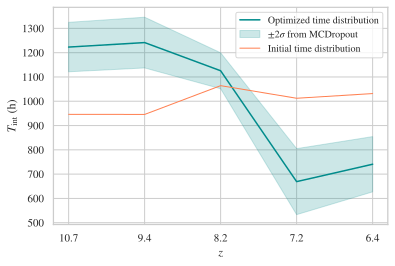

In [15]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.plot(mean, label = 'Optimized time distribution', color="darkcyan")
plt.fill_between(range(5), mean-2*var**0.5, mean+2*var**0.5, color='darkcyan',
                 label='$\\pm 2\\sigma$ from MCDropout', alpha=0.2)
plt.plot(times0.cpu().detach().numpy(), c='coral', lw=1, label='Initial time distribution')
plt.legend(fontsize=10)
plt.xticks(np.arange(5))
redsString = [str("%.1f"%r) for r in reds]
ax.set_xticklabels(redsString)
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$T_{\rm int}$ (h)")
plt.show()

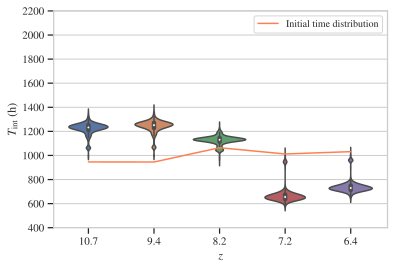

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
timeListFrame = pd.DataFrame(timeList, columns=["%.1f"%z for z in reds])
ax = sns.violinplot(data=timeListFrame, lw=1)
ax.plot(times0.cpu().detach().numpy(), c="coral", label="Initial time distribution")
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$T_{\rm int}$ (h)")
ax.legend(fontsize=10)
ax.tick_params(bottom=True, left=True)
ax.set_ylim(400, 2200);
plt.savefig("./Figures/optimizedTime3params.pdf", bbox_inches="tight")